In [21]:
import os
import scipy
from skimage.transform import resize
import numpy as np
import tqdm
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Flatten
from keras import backend as K
from keras.utils import to_categorical
from keras.optimizers import Adam,RMSprop,SGD

K.set_image_data_format('channels_last')

%matplotlib inline

Training Set

In [2]:
train0_namelist = os.listdir('chest_xray/train/NORMAL')
train0_namelist = train0_namelist[1:]
train1_namelist = os.listdir('chest_xray/train/PNEUMONIA')
train1_namelist = train1_namelist[1:]
num_train0 = len(train0_namelist)
print ('Num of Normal in Train = ', num_train0)
num_train1 = len(train1_namelist)
print ('Num of Pneumonia in Train = ', num_train1)
print ('Training Data Size = ' , num_train0 + num_train1)

Num of Normal in Train =  1341
Num of Pneumonia in Train =  3875
Training Data Size =  5216


In [22]:
Train_x = []
Train_y = []
for image_name in tqdm(train0_namelist):
    im = cv2.imread('chest_xray/train/NORMAL/' + image_name)
    im = resize(im/255.,(128,128,3))
    #im = scipy.misc.imresize(im,(128,128,3))
    Train_x.append(im)
    Train_y.append(0)
    
for image_name in tqdm(train1_namelist):
    im = cv2.imread('chest_xray/train/PNEUMONIA/' + image_name)
    im = resize(im/255.,(128,128,3))
    #im = scipy.misc.imresize(im,(128,128,3))
    Train_x.append(im)
    Train_y.append(1)  
    
      

  0%|          | 0/1341 [00:00<?, ?it/s]/Users/allen/env/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/allen/env/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 3875/3875 [02:50<00:00, 22.67it/s]


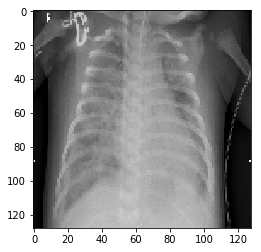

In [23]:
Train_x = np.array(Train_x)
Train_y = np.array(Train_y)
plt.imshow(Train_x[1341,:,:,:]) 

Test Set

In [24]:
test0_namelist = os.listdir('chest_xray/test/NORMAL')
test0_namelist = test0_namelist[1:]
test1_namelist = os.listdir('chest_xray/test/PNEUMONIA')
test1_namelist = test1_namelist[1:]
num_test0 = len(test0_namelist)
print ('Num of Normal in Test = ', num_test0)
num_test1 = len(test1_namelist)
print ('Num of Pneumonia in Test = ', num_test1)
print ('Training Data Size = ' , num_test0 + num_test1)

Num of Normal in Test =  233
Num of Pneumonia in Test =  389
Training Data Size =  622


In [25]:
Test_x = []
Test_y = []
for image_name in tqdm(test0_namelist):
    im = cv2.imread('chest_xray/test/NORMAL/' + image_name)
    im = resize(im,(128,128,3))
    #im = scipy.misc.imresize(im,(128,128,3))
    Test_x.append(im)
    Test_y.append(0)
    
for image_name in tqdm(test1_namelist):
    im = cv2.imread('chest_xray/test/PNEUMONIA/' + image_name)
    im = resize(im,(128,128,3))
    #im = scipy.misc.imresize(im,(128,128,3))
    Test_x.append(im)
    Test_y.append(1)  
    
Test_x = np.asarray(Test_x)
Test_y = np.asarray(Test_y)

Train_y = to_categorical(Train_y)
Test_y = to_categorical(Test_y)

print('Train_x.shape:',Train_x.shape)
print('Test_x.shape:',Test_x.shape)
print('Train_y.shape:',Train_y.shape)
print('Test_y.shape:',Test_y.shape)

  0%|          | 0/233 [00:00<?, ?it/s]/Users/allen/env/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/allen/env/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 389/389 [00:11<00:00, 33.32it/s]


Train_x.shape: (5216, 128, 128, 3)
Test_x.shape: (622, 128, 128, 3)
Train_y.shape: (5216, 2)
Test_y.shape: (622, 2)


In [52]:
# create the base pre-trained model
base_model = VGG16(include_top=False,classes=2,input_shape=(128,128,3))
x = base_model.output

for layer in base_model.layers:
    layer.trainable = False

In [53]:
x.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'block5_pool_3/MaxPool:0' shape=(?, 4, 4, 512) dtype=float32>>

In [54]:
x = Flatten()(x)
#x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [56]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(Train_x,Train_y,epochs=1,batch_size=50)

Epoch 1/1
5216/5216 [==============================] - 453s 87ms/step - loss: 0.1571 - acc: 0.9408


In [58]:
temp = model.evaluate(Test_x,Test_y)
print ('Loss of test set = ', temp[0])
print ('Accuracy = ', temp[1])

622/622 [==============================] - 47s 75ms/step
Loss of test set =  0.3494016151467991
Accuracy =  0.864951768488746


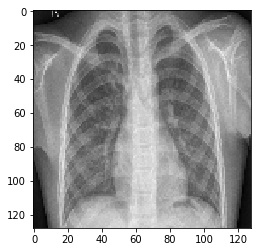

In [59]:
plt.imshow(Test_x[10,:,:,:])

In [60]:
prob = model.predict(np.expand_dims(Test_x[70,:,:,:], axis=0))
print ('P(Normal) = ', prob[0][0])
print ('P(Pneumonia) = ', prob[0][1])

if prob[0][0] > prob[0][1]:
    print ('Normal')
elif prob[0][0] < prob[0][1]:
    print ('Pneumonia')
else:
    print ('Equal probability')

P(Normal) =  0.8391398
P(Pneumonia) =  0.16086015
Normal
